# Import lib

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from keras.models import load_model
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [4]:
# !cp /commonlib.py .
!cp /aisf_jackie_library.py .

# from commonlib import *
from aisf_jackie_library import *

cp: cannot stat '/aisf_jackie_library.py': No such file or directory


ModuleNotFoundError: ignored

In [ ]:
class ModelResult:
  def __init__(self, modelName, gridsize, trainfilenum, testfile1num, testfile2num, paraAdic, paraBdic):
    self.modelName = modelName
    self.gridsize = gridsize

    self.trainfilenum = trainfilenum

    self.testfile1num = testfile1num
    self.testfile2num = testfile2num

    self.paraAdic = paraAdic

    self.paraBdic = paraBdic

  def getName(self):
    return self.modelName
  
  def getTrainFileNum(self):
    return self.trainfilenum

  def getTestAFileNum(self):
    return self.testfile1num
  
  def getTestBFileNum(self):
    return self.testfile2num
  
  def getParameter_testa(self):
    return self.paraAdic
  
  def getParameter_testb(self):
    return self.paraBdic
  
  def showresult(self):
    print('predicting base on test outfile{}....'.format(self.testfile1num))
    print('RMSE: %.4f' % (self.paraAdic['RMSE']))
    print('MAE: %.4f' % (self.paraAdic['MAE']))
    print('MSE: %.4f' % (self.paraAdic['MSE']))
    print('R^2: %.4f' % (self.paraAdic['R2']))
    print()
    print('predicting base on test outfile{}....'.format(self.testfile2num))
    print('RMSE: %.4f' % (self.paraBdic['RMSE']))
    print('MAE: %.4f' % (self.paraBdic['MAE']))
    print('MSE: %.4f' % (self.paraBdic['MSE']))
    print('R^2: %.4f' % (self.paraBdic['R2']))
    print("______End_______")





In [8]:
def load_model_from_path(gsize,trainfilenum,shuffle,batch):
  print('LSTM Model build base on file' + str(trainfilenum))
  modelpath = '/content/drive/MyDrive/ColabNotebooks/{size}mm_file/outfile{fnum}/Model_shuff{shuff}_bch{batchsize}.h5'.format(
      size = gsize, fnum = trainfilenum, shuff = str(shuffle), batchsize = batch)
  model = load_model(modelpath)
  return model

def get_prediction_result(model, test_x, test_lable,testfilenum):
  print("predicting base on test outfile{testf}....".format(testf = testfilenum))
  y_pred = model.predict(test_x, verbose=1)
  score = r2_score(test_lable, y_pred)


  rmse = mean_squared_error(test_lable, y_pred, squared=False)
  mae = mean_absolute_error(test_lable, y_pred)
  mse = mean_squared_error(test_lable, y_pred)
  r2 = score

  paradic = {
      "testfilenum": testfilenum,
      "RMSE": rmse,
      "MAE" : mae,
      "MSE" : mse,
      "R2" : r2
      }
  
  print("RMSE: %.4f" % (mean_squared_error(test_lable, y_pred, squared=False)))
  print("MAE: %.4f" % (mean_absolute_error(test_lable, y_pred)))
  print("MSE: %.4f" % (mean_squared_error(test_lable, y_pred)))
  print("Rsquare: %.4f" % (score))
  print("___finished___")
  
  return paradic


def get_model_history(gsize,trainfilenum,shuffle,batch):
  historypth = '/content/drive/MyDrive/ColabNotebooks/{size}mm_file/outfile{fnum}/Model_shuff{shuff}_bch{batchsize}.pickle'.format(
      size = gsize, fnum = trainfilenum, shuff = str(shuffle), batchsize = batch)
  with open(historypth, 'rb') as file_pi:
    history=pickle.load(file_pi)
  return history



def show_loss_pic(history):
  print('LSTM Model Loss history when build base on file' + str(trainfilenum))
  plt.figure(figsize=(16,8))
  plt.plot(history['loss'], label='train loss')
  plt.plot(history['val_loss'], label='val loss')
  plt.title("LOSS")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()


def get_testfile(gsize,testfilenum,shuffle,batch):
  testfilepath = '/content/drive/MyDrive/ColabNotebooks/{size}mm_file/outfile{filenum}/trainingfile_{size}mm.txt'.format(size = gsize, filenum = testfilenum)
  dataset_x = []
  dataset_y = []
  with open(testfilepath, 'r') as f_test:
      lines = f_test.readlines()
      for line in lines:
          line = line.strip("\n")
          dataset_x.append(line.split("|")[0].split(","))
          dataset_y.append(line.split("|")[1])
  lable = [float(y) for y in dataset_y]
  input_x = []
  for grp in dataset_x:
      input_x.append([float(z) for z in grp])
      
  test_x,test_lable = create_dataset(input_x, lable)
  
  return test_x, test_lable

### main for lstm
def start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle):
  testa_x, testa_y = get_testfile(gsize,testfile1num,shuffle,batch)
  testb_x, testb_y = get_testfile(gsize,testfile2num,shuffle,batch)

  model = load_model_from_path(gsize,trainfilenum,shuffle,batch)

  history = get_model_history(gsize,trainfilenum,shuffle,batch)
  show_loss_pic(history)

  paradicA = get_prediction_result(model,testa_x, testa_y,testfile1num)
  print()
  paradicB = get_prediction_result(model,testb_x, testb_y,testfile2num)
  
  lstm_obj = ModelResult('LSTM', gsize, trainfilenum, testfile1num, testfile2num, paradicA, paradicB)
  return lstm_obj



def reshapedata_2d(testa_x, testb_x):

  nsamplea,nxa,nya = testa_x.shape
  x_testa_2d = testa_x.reshape(nsamplea, nxa*nya)
  
  nsampleb,nxb,nyb = testb_x.shape
  x_testb_2d = testb_x.reshape(nsampleb, nxb*nyb)

  return x_testa_2d, x_testb_2d


def load_lasso(gsize, trainfilenum):
  pkl_filename = '/content/drive/MyDrive/ColabNotebooks/{size}mm_file/outfile{fnum}/Model_lasso.pickle'.format(
      size = gsize, fnum = trainfilenum)
  with open(pkl_filename, 'rb') as file:
      model = pickle.load(file)
  return model


def getpredictresult_lasso(testfilenum, model, x_test_2d, y_test, seed):
  yhat = model.predict(x_test_2d)
  # evaluate model
  mse = mean_squared_error(y_test, yhat)
  r2 = r2_score(y_test, yhat)
  mae = mean_absolute_error(y_test, yhat)
  rmse = mean_squared_error(y_test, yhat, squared = False)
  # force scores to be positive
  print('RMSE: %.4f' % (abs(rmse.mean())))
  print('MAE: %.4f' % (abs(mae.mean())))
  print('MSE: %.4f' % (abs(mse.mean())))
  print('R^2: %.4f' % (r2))
  
  paradic = {
      "testfilenum": testfilenum,
      "RMSE": rmse,
      "MAE" : mae,
      "MSE" : mse,
      "R2" : r2
      }

  return paradic


####main for lasso
def lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle, seed):
  testa_x, testa_y = get_testfile(gsize,testfile1num,shuffle,batch)
  testb_x, testb_y = get_testfile(gsize,testfile2num,shuffle,batch)
  x_testa_2d, x_testb_2d = reshapedata_2d(testa_x, testb_x)

  lasso = load_lasso(gsize,trainfilenum)
  print("model build on outfile{trainfnum}, gridsize = {size}...".format(trainfnum = trainfilenum, size = gsize))
  print()
  print("predicting base on test outfile{testfnum}".format(testfnum = testfile1num))
  paradicA = getpredictresult_lasso(testfile1num, lasso, x_testa_2d, testa_y, seed)
  print("___finished___")
  
  print( )
  print("predicting base on test outfile{testfnum}".format(testfnum = testfile2num))
  paradicB = getpredictresult_lasso(testfile2num,lasso, x_testb_2d, testb_y, seed)
  print("___finished___")
  lasso_obj = ModelResult('LASSO', gsize, trainfilenum, testfile1num, testfile2num, paradicA, paradicB)

  return lasso_obj


def load_svm(gsize, trainfilenum):
  pkl_filename = '/content/drive/MyDrive/ColabNotebooks/{size}mm_file/outfile{fnum}/Model_svm.pickle'.format(
      size = gsize, fnum = trainfilenum)
  with open(pkl_filename, 'rb') as file:
      model = pickle.load(file)
  return model


def getpredictresult_svm(testfilenum, model, x_test_2d, y_test, seed):
  yhat = model.predict(x_test_2d)
  # evaluate model
  mse = mean_squared_error(y_test, yhat)
  r2 = r2_score(y_test, yhat)
  mae = mean_absolute_error(y_test, yhat)
  rmse = mean_squared_error(y_test, yhat, squared = False)
  # force scores to be positive
  print('RMSE: %.4f' % (abs(rmse.mean())))
  print('MAE: %.4f' % (abs(mae.mean())))
  print('MSE: %.4f' % (abs(mse.mean())))
  print('R^2: %.4f' % (r2))
  
  paradic = {
      "testfilenum": testfilenum,
      "RMSE": rmse,
      "MAE" : mae,
      "MSE" : mse,
      "R2" : r2
      }
  return paradic



def svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle, seed):
  testa_x, testa_y = get_testfile(gsize,testfile1num,shuffle,batch)
  testb_x, testb_y = get_testfile(gsize,testfile2num,shuffle,batch)
  x_testa_2d, x_testb_2d = reshapedata_2d(testa_x, testb_x)
  svm = load_svm(gsize,trainfilenum)
  print("model build on outfile{trainfnum}, gridsize = {size}...".format(trainfnum = trainfilenum, size = gsize))
  print()
  print("predicting base on test outfile{testfnum}".format(testfnum = testfile1num))
  paradicA = getpredictresult_svm(testfile1num, svm, x_testa_2d, testa_y, seed)
  print("___finished___")
  
  print( )
  print("predicting base on test outfile{testfnum}".format(testfnum = testfile2num))
  paradicB = getpredictresult_svm(testfile2num,svm, x_testb_2d, testb_y, seed)
  print("___finished___")
  svm_obj = ModelResult('svm', gsize, trainfilenum, testfile1num, testfile2num, paradicA, paradicB)
  return svm_obj




#global var
batch = 16
shuffle = True 
seed = 2


# 2 mm model



In [5]:
batch_2mm = 128
gsize = 2

## file1

In [6]:
trainfilenum = 1

testfile1num = 2
testfile2num = 3

LSTM Model build base on file1
LSTM Model Loss history when build base on file1


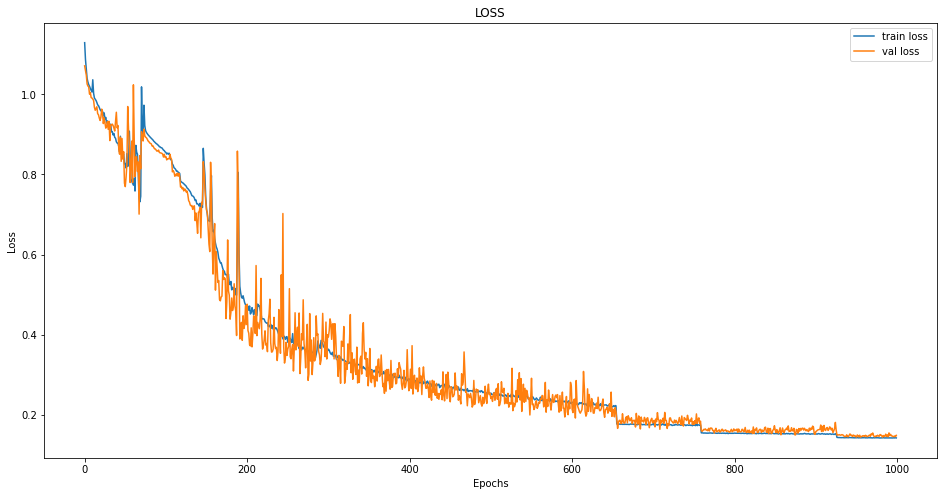

predicting base on test outfile2....
857/857 [==============================] - 4s 4ms/step
RMSE: 0.4248
MAE: 0.3049
MSE: 0.1804
Rsquare: 0.9270
___finished___

predicting base on test outfile3....
858/858 [==============================] - 4s 4ms/step
RMSE: 0.4520
MAE: 0.3716
MSE: 0.2043
Rsquare: 0.9076
___finished___


In [ ]:
#LSTM
lstm_obj2mmf1 = start_main(trainfilenum,testfile1num,testfile2num,batch_2mm,gsize,shuffle)

In [ ]:
#SVM
svm_obj2mmf1 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile1, gridsize = 2...

predicting base on test outfile2
RMSE: 0.9480
MAE: 0.6957
MSE: 0.8988
R^2: 0.6364
___finished___

predicting base on test outfile3
RMSE: 0.8210
MAE: 0.6156
MSE: 0.6741
R^2: 0.6951
___finished___


In [ ]:
# LASSO
# lasso_obj2mmf1 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

## file2

In [ ]:
trainfilenum = 2

testfile1num = 1
testfile2num = 3

LSTM Model build base on file2
LSTM Model Loss history when build base on file2


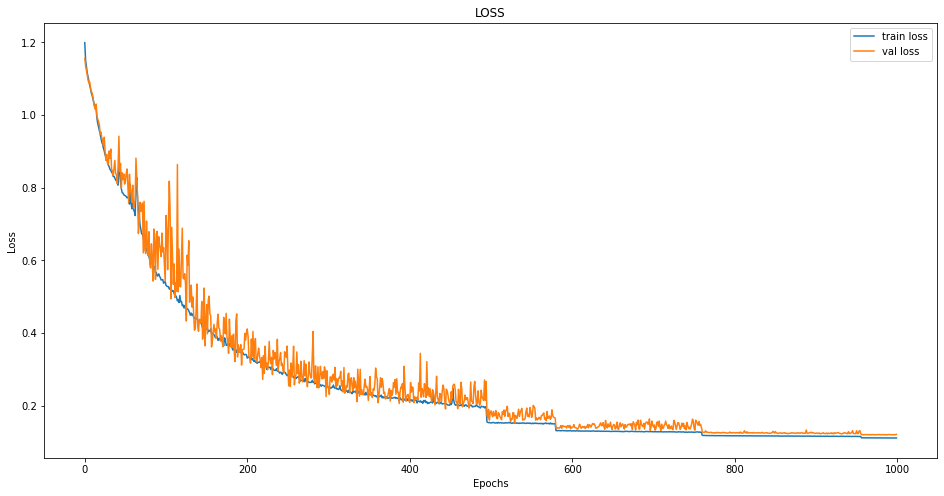

predicting base on test outfile1....
865/865 [==============================] - 4s 4ms/step
RMSE: 0.4452
MAE: 0.3164
MSE: 0.1982
Rsquare: 0.9077
___finished___

predicting base on test outfile3....
858/858 [==============================] - 4s 4ms/step
RMSE: 0.3641
MAE: 0.2890
MSE: 0.1326
Rsquare: 0.9400
___finished___


In [ ]:
#LSTM
lstm_obj2mmf2 = start_main(trainfilenum,testfile1num,testfile2num,batch_2mm,gsize,shuffle)

In [ ]:
#SVM
svm_obj2mmf2 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile2, gridsize = 2...

predicting base on test outfile1
RMSE: 0.9540
MAE: 0.7032
MSE: 0.9102
R^2: 0.5761
___finished___

predicting base on test outfile3
RMSE: 0.7906
MAE: 0.5926
MSE: 0.6251
R^2: 0.7173
___finished___


In [ ]:
# LASSO
# lsso_obj2mmf2 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

## file3

In [ ]:
trainfilenum = 3

testfile1num = 1
testfile2num = 2

LSTM Model build base on file3
LSTM Model Loss history when build base on file3


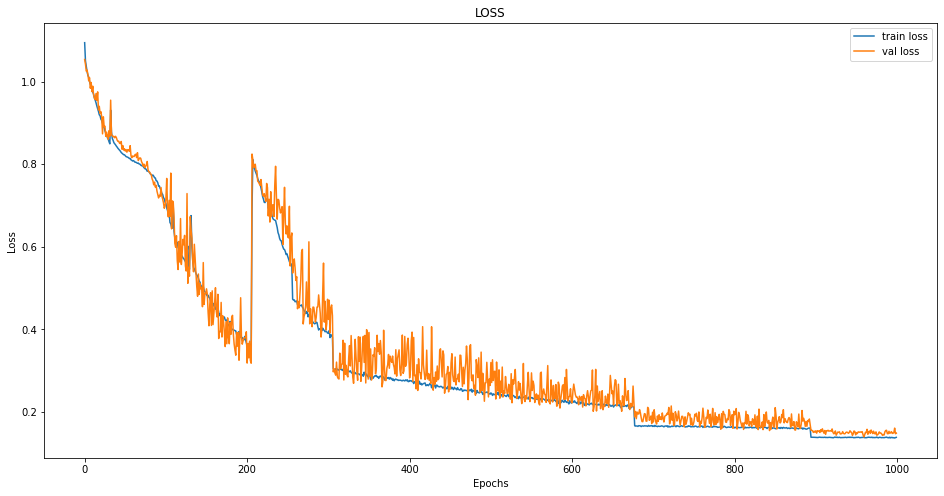

predicting base on test outfile1....
865/865 [==============================] - 4s 4ms/step
RMSE: 0.4854
MAE: 0.4009
MSE: 0.2357
Rsquare: 0.8902
___finished___

predicting base on test outfile2....
857/857 [==============================] - 4s 4ms/step
RMSE: 0.3980
MAE: 0.3217
MSE: 0.1584
Rsquare: 0.9359
___finished___


In [ ]:
#LSTM
lstm_obj2mmf3 = start_main(trainfilenum,testfile1num,testfile2num,batch_2mm,gsize,shuffle)

In [ ]:
#SVM
svm_obj2mmf3 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile3, gridsize = 2...

predicting base on test outfile1
RMSE: 0.9413
MAE: 0.6966
MSE: 0.8861
R^2: 0.5873
___finished___

predicting base on test outfile2
RMSE: 0.9183
MAE: 0.6695
MSE: 0.8433
R^2: 0.6589
___finished___


In [ ]:
# LASSO
# lasso_obj2mmf3 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

# 5 mm model

In [ ]:
gsize = 5

## file1

In [ ]:
trainfilenum = 1

testfile1num = 2
testfile2num = 3

LSTM Model build base on file1
LSTM Model Loss history when build base on file1


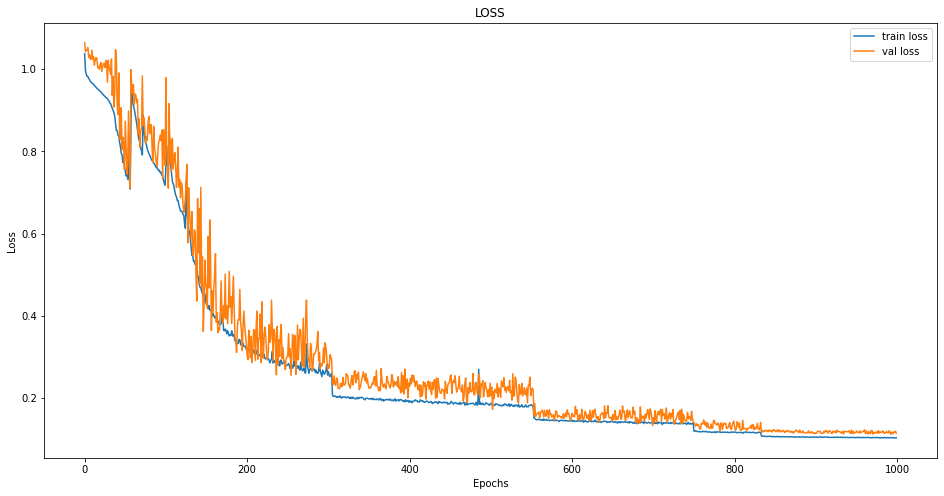

predicting base on test outfile2....
133/133 [==============================] - 1s 4ms/step
RMSE: 0.3995
MAE: 0.2822
MSE: 0.1596
Rsquare: 0.9215
___finished___

predicting base on test outfile3....
133/133 [==============================] - 1s 4ms/step
RMSE: 0.4287
MAE: 0.3488
MSE: 0.1838
Rsquare: 0.8973
___finished___


In [ ]:
#LSTM
lstm_obj5mmf1 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj5mmf1 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile1, gridsize = 5...

predicting base on test outfile2
RMSE: 0.6338
MAE: 0.4750
MSE: 0.4017
R^2: 0.8025
___finished___

predicting base on test outfile3
RMSE: 0.5484
MAE: 0.4226
MSE: 0.3008
R^2: 0.8320
___finished___


In [ ]:
# LASSO
# lasso_obj5mmf1 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

## file2

In [ ]:
trainfilenum = 2

testfile1num = 1
testfile2num = 3

LSTM Model build base on file2
LSTM Model Loss history when build base on file2


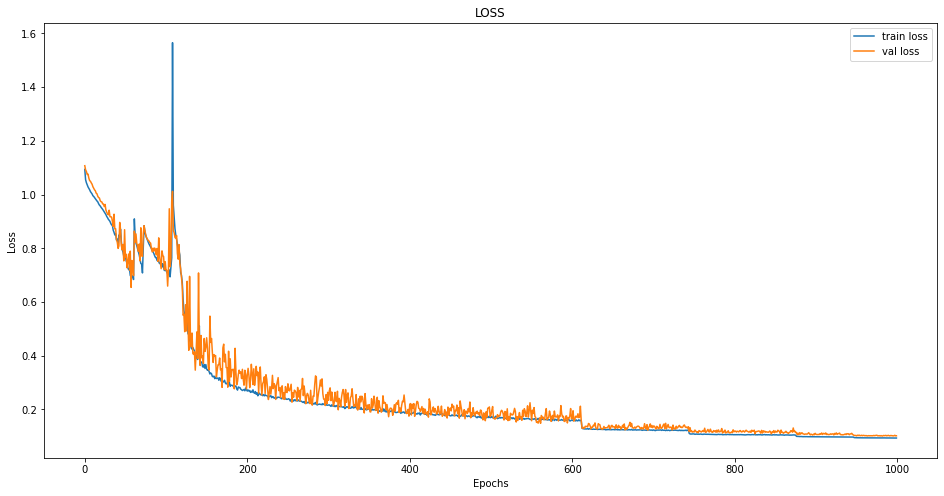

predicting base on test outfile1....
133/133 [==============================] - 1s 4ms/step
RMSE: 0.4050
MAE: 0.2877
MSE: 0.1640
Rsquare: 0.9059
___finished___

predicting base on test outfile3....
133/133 [==============================] - 1s 4ms/step
RMSE: 0.3521
MAE: 0.2800
MSE: 0.1239
Rsquare: 0.9308
___finished___


In [ ]:
#LSTM

lstm_obj5mmf2 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj5mmf2 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile2, gridsize = 5...

predicting base on test outfile1
RMSE: 0.6341
MAE: 0.4753
MSE: 0.4021
R^2: 0.7692
___finished___

predicting base on test outfile3
RMSE: 0.5019
MAE: 0.3899
MSE: 0.2519
R^2: 0.8593
___finished___


In [ ]:
# LASSO
# lasso_obj5mmf2 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

## file3

In [ ]:
trainfilenum = 3

testfile1num = 1
testfile2num = 2

LSTM Model build base on file3
LSTM Model Loss history when build base on file3


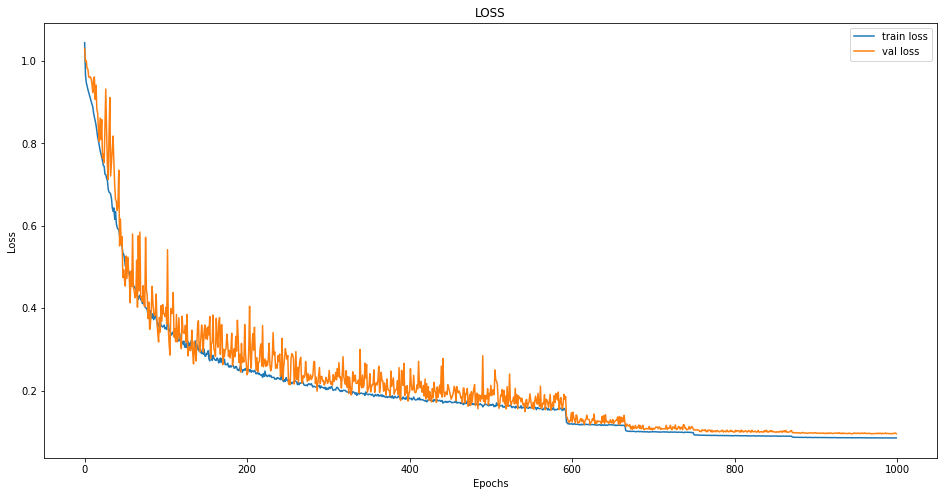

predicting base on test outfile1....
133/133 [==============================] - 1s 4ms/step
RMSE: 0.4332
MAE: 0.3536
MSE: 0.1876
Rsquare: 0.8923
___finished___

predicting base on test outfile2....
133/133 [==============================] - 1s 4ms/step
RMSE: 0.3594
MAE: 0.2877
MSE: 0.1291
Rsquare: 0.9365
___finished___


In [ ]:
#LSTM
lstm_obj5mmf3 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj5mmf3 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile3, gridsize = 5...

predicting base on test outfile1
RMSE: 0.6570
MAE: 0.5056
MSE: 0.4317
R^2: 0.7522
___finished___

predicting base on test outfile2
RMSE: 0.6278
MAE: 0.4729
MSE: 0.3941
R^2: 0.8062
___finished___


In [ ]:
# LASSO
# lasso_obj5mmf3 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

# 10 mm model

In [ ]:
gsize = 10

## file1

In [ ]:
trainfilenum = 1

testfile1num = 2
testfile2num = 3

LSTM Model build base on file1
LSTM Model Loss history when build base on file1


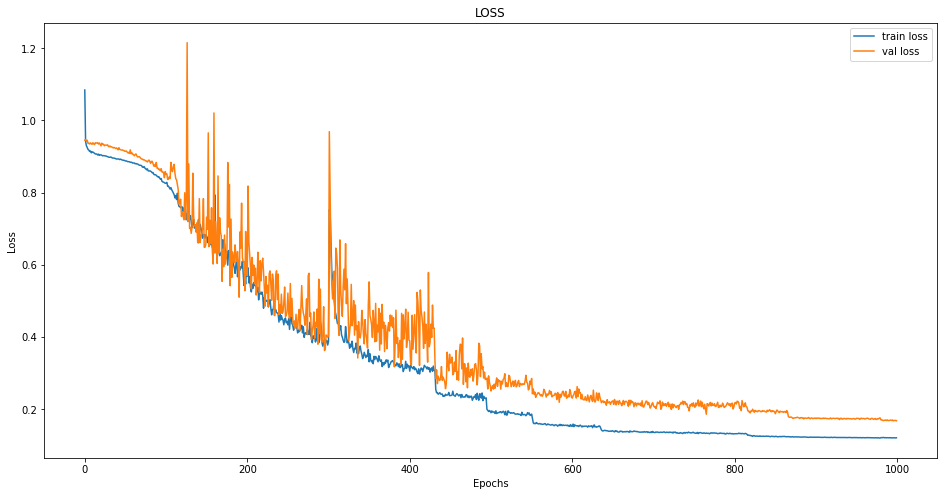

predicting base on test outfile2....
32/32 [==============================] - 0s 4ms/step
RMSE: 0.4257
MAE: 0.2828
MSE: 0.1812
Rsquare: 0.8881
___finished___

predicting base on test outfile3....
32/32 [==============================] - 0s 4ms/step
RMSE: 0.4485
MAE: 0.3525
MSE: 0.2011
Rsquare: 0.8534
___finished___


In [ ]:
#LSTM
lstm_obj10mmf1 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj10mmf1 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile1, gridsize = 10...

predicting base on test outfile2
RMSE: 0.4913
MAE: 0.3569
MSE: 0.2414
R^2: 0.8509
___finished___

predicting base on test outfile3
RMSE: 0.4749
MAE: 0.3650
MSE: 0.2255
R^2: 0.8357
___finished___


In [ ]:
# LASSO
# lasso_obj10mmf1 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

## file2

In [ ]:
trainfilenum = 2

testfile1num = 1
testfile2num = 3

LSTM Model build base on file2
LSTM Model Loss history when build base on file2


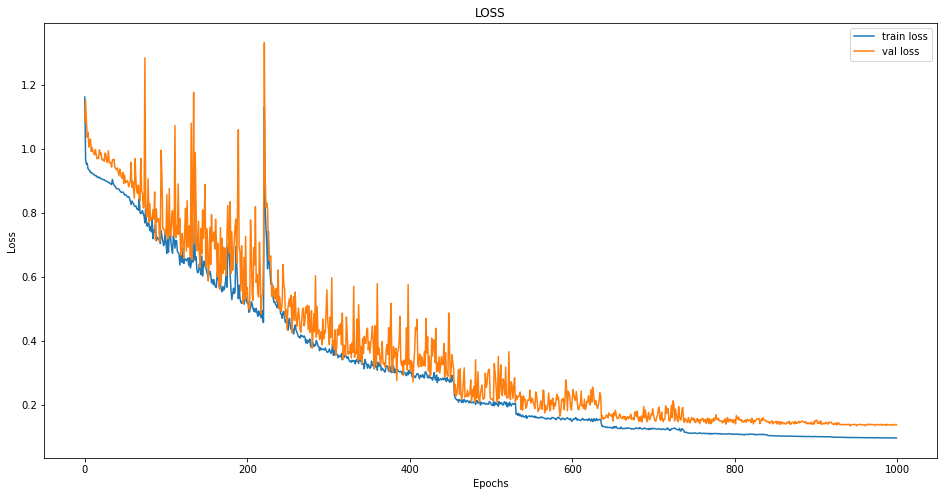

predicting base on test outfile1....
32/32 [==============================] - 0s 4ms/step
RMSE: 0.3722
MAE: 0.2667
MSE: 0.1385
Rsquare: 0.9058
___finished___

predicting base on test outfile3....
32/32 [==============================] - 0s 5ms/step
RMSE: 0.3628
MAE: 0.2935
MSE: 0.1317
Rsquare: 0.9041
___finished___


In [ ]:
#LSTM
lstm_obj10mmf2 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj10mmf2 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile2, gridsize = 10...

predicting base on test outfile1
RMSE: 0.4492
MAE: 0.3357
MSE: 0.2018
R^2: 0.8628
___finished___

predicting base on test outfile3
RMSE: 0.4141
MAE: 0.3234
MSE: 0.1715
R^2: 0.8750
___finished___


In [ ]:
# LASSO
# lasso_obj10mmf2 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

## file3

In [ ]:
trainfilenum = 3

testfile1num = 1
testfile2num = 2

LSTM Model build base on file3
LSTM Model Loss history when build base on file3


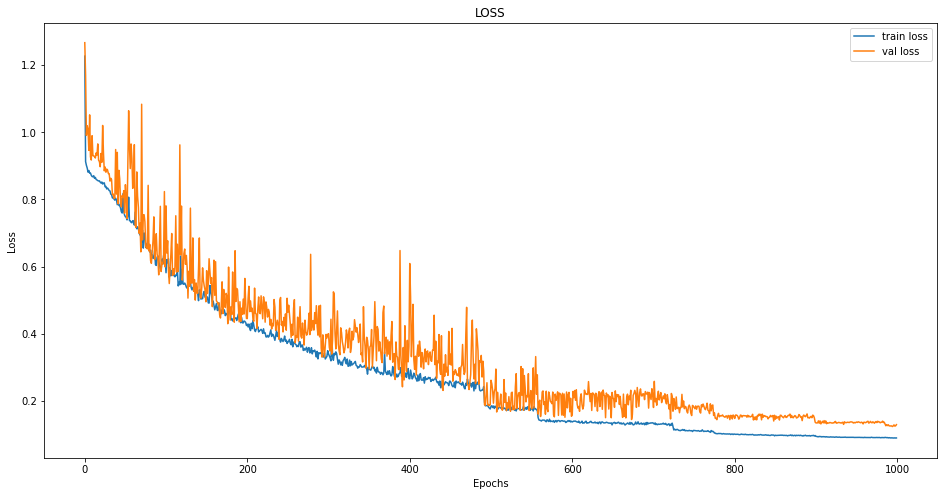

predicting base on test outfile1....
32/32 [==============================] - 0s 4ms/step
RMSE: 0.4152
MAE: 0.3304
MSE: 0.1724
Rsquare: 0.8828
___finished___

predicting base on test outfile2....
32/32 [==============================] - 0s 4ms/step
RMSE: 0.3640
MAE: 0.2752
MSE: 0.1325
Rsquare: 0.9182
___finished___


In [ ]:
#LSTM
lstm_obj10mmf3 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj10mmf3 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile3, gridsize = 10...

predicting base on test outfile1
RMSE: 0.4948
MAE: 0.3922
MSE: 0.2448
R^2: 0.8336
___finished___

predicting base on test outfile2
RMSE: 0.4882
MAE: 0.3822
MSE: 0.2383
R^2: 0.8528
___finished___


In [ ]:
# LASSO
# lasso_obj10mmf3 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

# 15 mm model

In [ ]:
gsize = 15

## file1


In [ ]:
trainfilenum = 1

testfile1num = 2
testfile2num = 3

LSTM Model build base on file1
LSTM Model Loss history when build base on file1


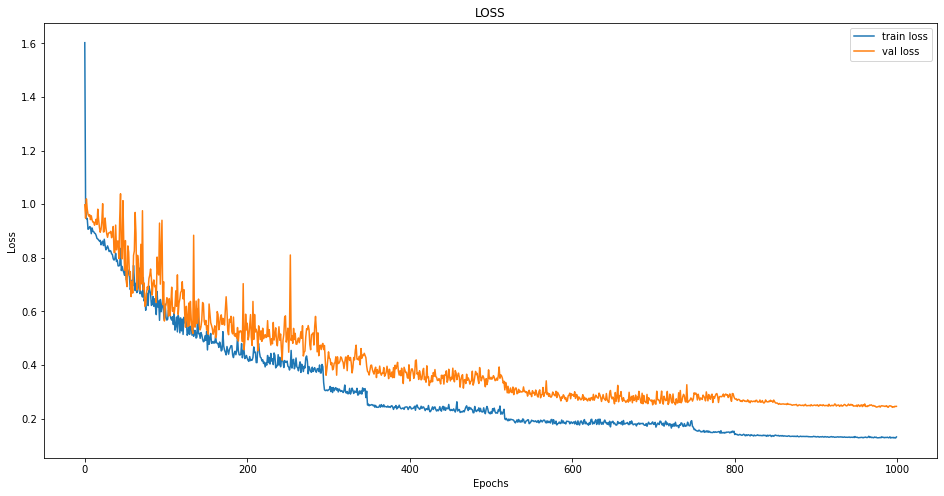

predicting base on test outfile2....
13/13 [==============================] - 0s 5ms/step
RMSE: 0.3876
MAE: 0.2722
MSE: 0.1503
Rsquare: 0.8959
___finished___

predicting base on test outfile3....
13/13 [==============================] - 0s 5ms/step
RMSE: 0.4479
MAE: 0.3600
MSE: 0.2006
Rsquare: 0.8297
___finished___


In [ ]:
#LSTM
lstm_obj15mmf1 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj15mmf1 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile1, gridsize = 15...

predicting base on test outfile2
RMSE: 0.4094
MAE: 0.2924
MSE: 0.1676
R^2: 0.8839
___finished___

predicting base on test outfile3
RMSE: 0.4381
MAE: 0.3414
MSE: 0.1920
R^2: 0.8370
___finished___


In [ ]:
# LASSO
# lasso_obj15mmf1 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

## file2

In [ ]:
trainfilenum = 2

testfile1num = 1
testfile2num = 3

LSTM Model build base on file2
LSTM Model Loss history when build base on file2


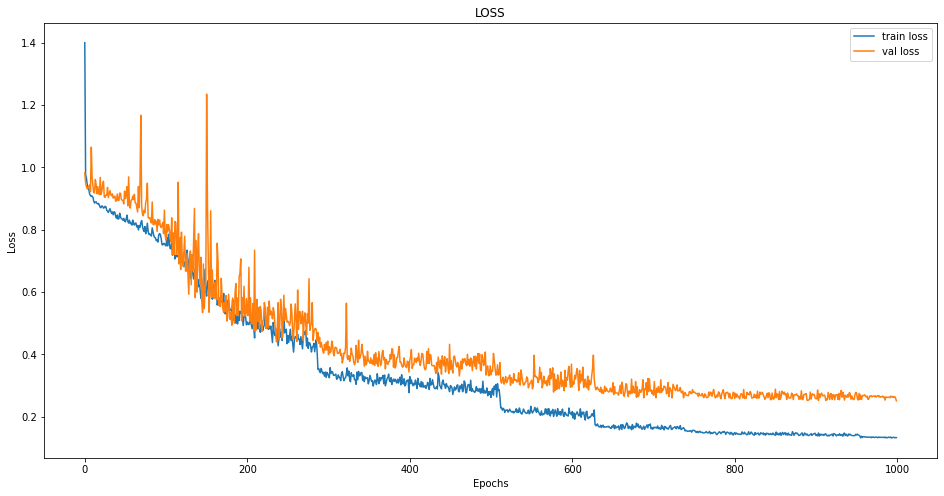

predicting base on test outfile1....
13/13 [==============================] - 0s 4ms/step
RMSE: 0.3694
MAE: 0.2750
MSE: 0.1364
Rsquare: 0.9045
___finished___

predicting base on test outfile3....
13/13 [==============================] - 0s 4ms/step
RMSE: 0.3977
MAE: 0.3120
MSE: 0.1582
Rsquare: 0.8657
___finished___


In [ ]:
#LSTM

lstm_obj15mmf2 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj15mmf2 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile2, gridsize = 15...

predicting base on test outfile1
RMSE: 0.3794
MAE: 0.2854
MSE: 0.1440
R^2: 0.8992
___finished___

predicting base on test outfile3
RMSE: 0.4046
MAE: 0.3181
MSE: 0.1637
R^2: 0.8610
___finished___


In [ ]:
# LASSO
# lasso_obj15mmf2 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

## file3

In [ ]:
trainfilenum = 3

testfile1num = 1
testfile2num = 2

LSTM Model build base on file3
LSTM Model Loss history when build base on file3


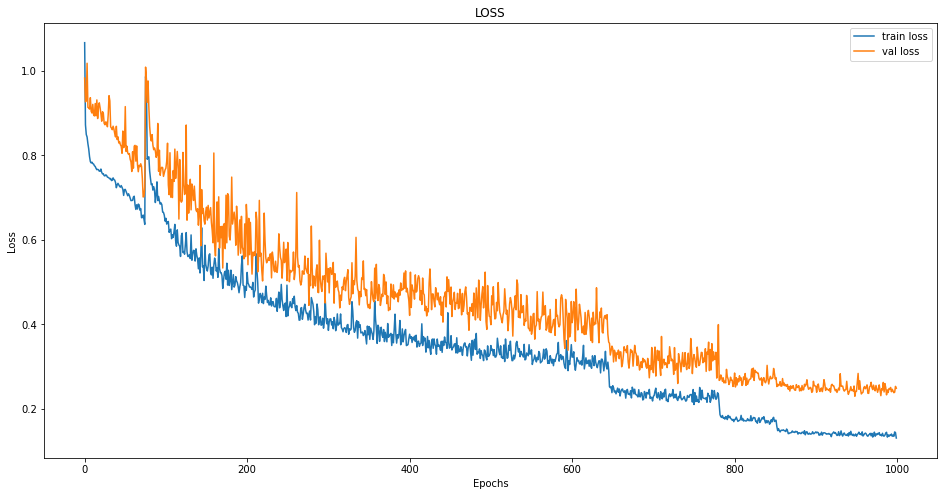

predicting base on test outfile1....
13/13 [==============================] - 0s 5ms/step
RMSE: 0.4287
MAE: 0.3491
MSE: 0.1838
Rsquare: 0.8714
___finished___

predicting base on test outfile2....
13/13 [==============================] - 0s 4ms/step
RMSE: 0.4113
MAE: 0.3091
MSE: 0.1692
Rsquare: 0.8828
___finished___


In [ ]:
#LSTM
lstm_obj15mmf3 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_bj15mmf3 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile3, gridsize = 15...

predicting base on test outfile1
RMSE: 0.4501
MAE: 0.3587
MSE: 0.2026
R^2: 0.8582
___finished___

predicting base on test outfile2
RMSE: 0.4476
MAE: 0.3472
MSE: 0.2004
R^2: 0.8612
___finished___


In [ ]:
# LASSO
# lasso_obj15mmf3 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

# 20 mm model

In [ ]:
gsize = 20

## file1

In [ ]:
trainfilenum = 1

testfile1num = 2
testfile2num = 3

LSTM Model build base on file1
LSTM Model Loss history when build base on file1


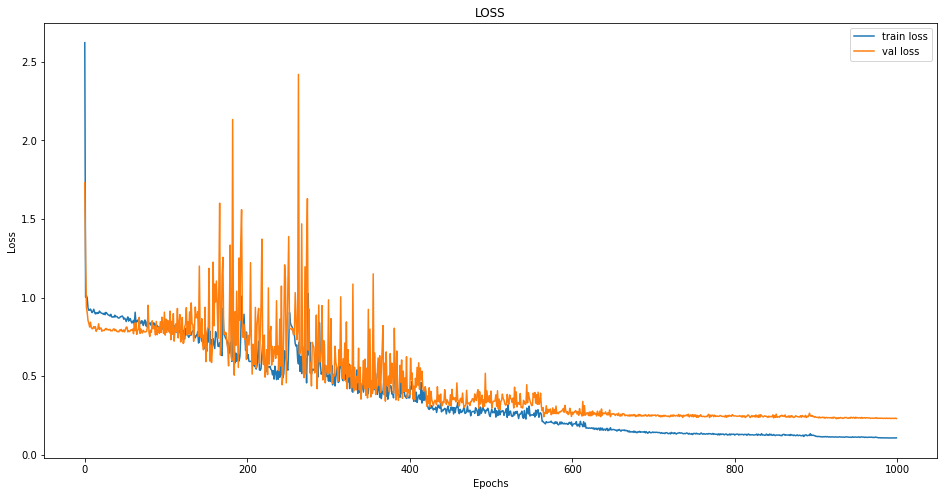

predicting base on test outfile2....
7/7 [==============================] - 0s 5ms/step
RMSE: 0.3564
MAE: 0.2472
MSE: 0.1270
Rsquare: 0.9111
___finished___

predicting base on test outfile3....
7/7 [==============================] - 0s 5ms/step
RMSE: 0.4007
MAE: 0.3209
MSE: 0.1606
Rsquare: 0.8615
___finished___


In [ ]:
#LSTM
lstm_obj20mmf1 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj20mmf1 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile1, gridsize = 20...

predicting base on test outfile2
RMSE: 0.3909
MAE: 0.2752
MSE: 0.1528
R^2: 0.8930
___finished___

predicting base on test outfile3
RMSE: 0.4041
MAE: 0.3085
MSE: 0.1633
R^2: 0.8592
___finished___


In [ ]:
# LASSO
# lasso_obj20mmf1 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)


## file2

In [ ]:
trainfilenum = 2

testfile1num = 1
testfile2num = 3

LSTM Model build base on file2
LSTM Model Loss history when build base on file2


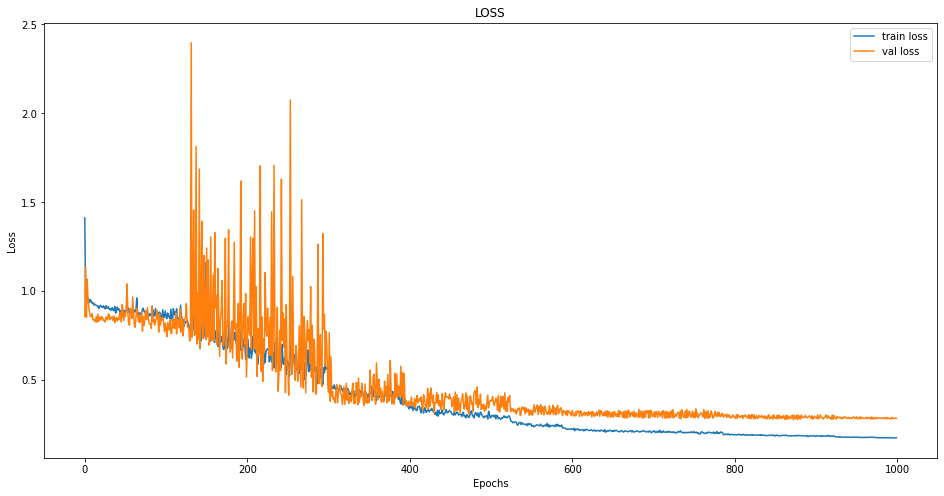

predicting base on test outfile1....
7/7 [==============================] - 0s 4ms/step
RMSE: 0.4070
MAE: 0.2923
MSE: 0.1657
Rsquare: 0.8810
___finished___

predicting base on test outfile3....
7/7 [==============================] - 0s 4ms/step
RMSE: 0.4157
MAE: 0.3185
MSE: 0.1728
Rsquare: 0.8510
___finished___


In [ ]:
#LSTM
lstm_obj20mmf2 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj20mmf2 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile2, gridsize = 20...

predicting base on test outfile1
RMSE: 0.3240
MAE: 0.2493
MSE: 0.1050
R^2: 0.9246
___finished___

predicting base on test outfile3
RMSE: 0.3420
MAE: 0.2712
MSE: 0.1170
R^2: 0.8991
___finished___


In [ ]:
# LASSO
# lasso_obj20mmf2 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

## file3

In [ ]:
trainfilenum = 3

testfile1num = 1
testfile2num = 2

LSTM Model build base on file3
LSTM Model Loss history when build base on file3


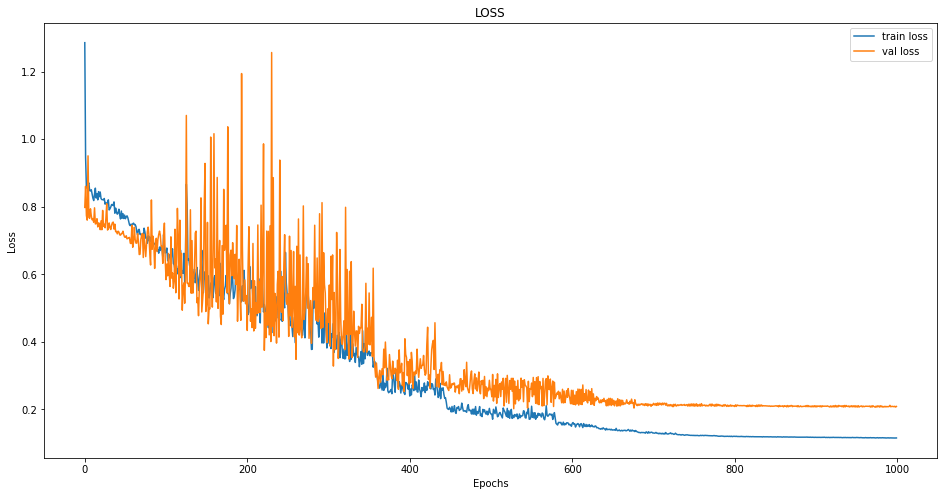

predicting base on test outfile1....
7/7 [==============================] - 0s 5ms/step
RMSE: 0.4258
MAE: 0.3308
MSE: 0.1813
Rsquare: 0.8698
___finished___

predicting base on test outfile2....
7/7 [==============================] - 0s 5ms/step
RMSE: 0.4201
MAE: 0.3073
MSE: 0.1765
Rsquare: 0.8764
___finished___


In [ ]:
#LSTM
lstm_obj20mmf3 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj20mmf3 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile3, gridsize = 20...

predicting base on test outfile1
RMSE: 0.4099
MAE: 0.3314
MSE: 0.1680
R^2: 0.8793
___finished___

predicting base on test outfile2
RMSE: 0.4064
MAE: 0.3196
MSE: 0.1651
R^2: 0.8844
___finished___


In [ ]:
# LASSO
# lasso_obj20mmf3 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

# 30 mm model

In [ ]:
gsize = 30

## file1

In [ ]:
trainfilenum = 1

testfile1num = 2
testfile2num = 3

LSTM Model build base on file1
LSTM Model Loss history when build base on file1


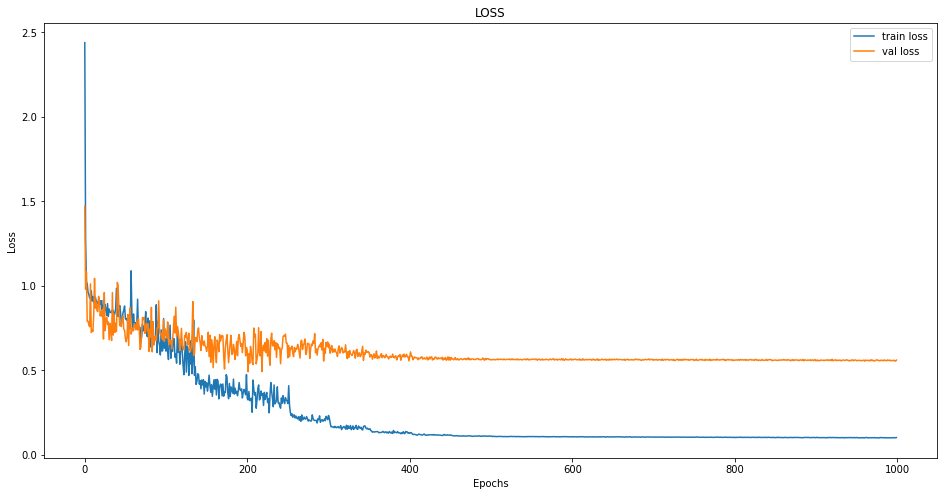

predicting base on test outfile2....
3/3 [==============================] - 0s 6ms/step
RMSE: 0.5087
MAE: 0.2982
MSE: 0.2588
Rsquare: 0.8232
___finished___

predicting base on test outfile3....
3/3 [==============================] - 0s 7ms/step
RMSE: 0.5001
MAE: 0.3541
MSE: 0.2501
Rsquare: 0.7854
___finished___


In [ ]:
#LSTM
lstm_obj30mmf1 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj30mmf1 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile1, gridsize = 30...

predicting base on test outfile2
RMSE: 0.3195
MAE: 0.2342
MSE: 0.1021
R^2: 0.9303
___finished___

predicting base on test outfile3
RMSE: 0.3483
MAE: 0.2874
MSE: 0.1213
R^2: 0.8959
___finished___


In [ ]:
# LASSO
# lasso_obj20mmf1 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)


## file2

In [ ]:
trainfilenum = 2

testfile1num = 1
testfile2num = 3

LSTM Model build base on file2
LSTM Model Loss history when build base on file2


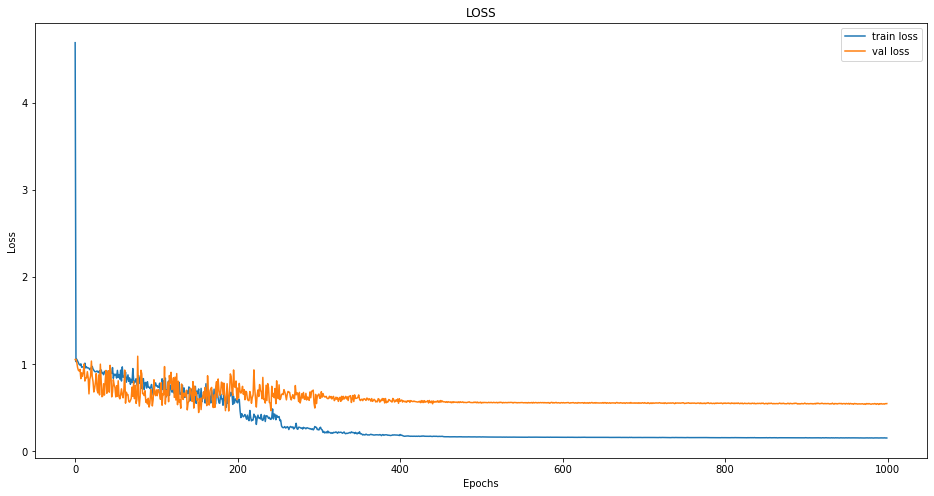

predicting base on test outfile1....
3/3 [==============================] - 0s 6ms/step
RMSE: 0.4786
MAE: 0.2880
MSE: 0.2290
Rsquare: 0.8442
___finished___

predicting base on test outfile3....
3/3 [==============================] - 0s 6ms/step
RMSE: 0.4651
MAE: 0.3081
MSE: 0.2163
Rsquare: 0.8144
___finished___


In [ ]:
#LSTM
lstm_obj30mmf2 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj30mmf2 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile2, gridsize = 30...

predicting base on test outfile1
RMSE: 0.3264
MAE: 0.2409
MSE: 0.1066
R^2: 0.9275
___finished___

predicting base on test outfile3
RMSE: 0.3513
MAE: 0.2762
MSE: 0.1234
R^2: 0.8941
___finished___


In [ ]:
# LASSO
# lasso_obj20mmf2 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

## file3

In [ ]:
trainfilenum = 3

testfile1num = 1
testfile2num = 2

LSTM Model build base on file3
LSTM Model Loss history when build base on file3


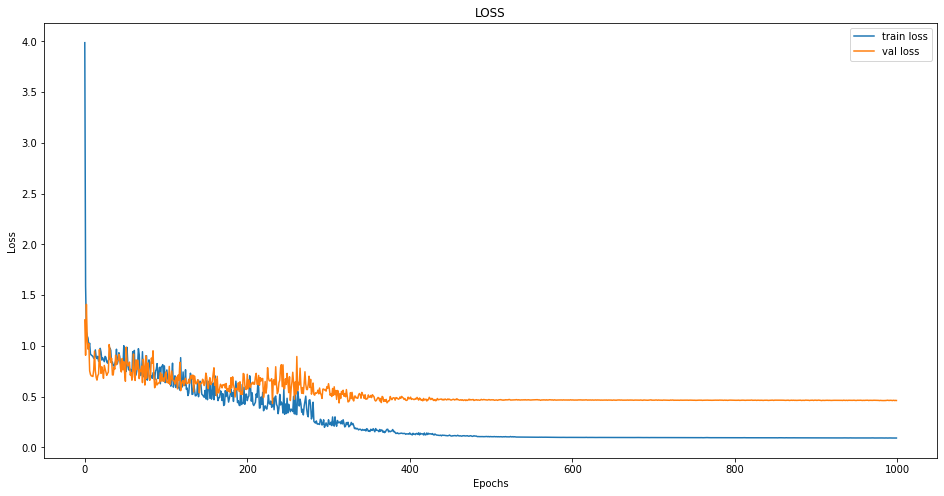

predicting base on test outfile1....
3/3 [==============================] - 0s 6ms/step
RMSE: 0.4657
MAE: 0.3705
MSE: 0.2169
Rsquare: 0.8525
___finished___

predicting base on test outfile2....
3/3 [==============================] - 0s 6ms/step
RMSE: 0.4657
MAE: 0.3457
MSE: 0.2169
Rsquare: 0.8519
___finished___


In [ ]:
#LSTM
lstm_obj30mmf3 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj30mmf3 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile3, gridsize = 30...

predicting base on test outfile1
RMSE: 0.4312
MAE: 0.3459
MSE: 0.1859
R^2: 0.8735
___finished___

predicting base on test outfile2
RMSE: 0.4243
MAE: 0.3413
MSE: 0.1800
R^2: 0.8770
___finished___


In [ ]:
# LASSO
# lasso_obj20mmf3 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

# 40 mm model

In [ ]:
gsize = 40

## file1

In [ ]:
trainfilenum = 1

testfile1num = 2
testfile2num = 3

LSTM Model build base on file1
LSTM Model Loss history when build base on file1


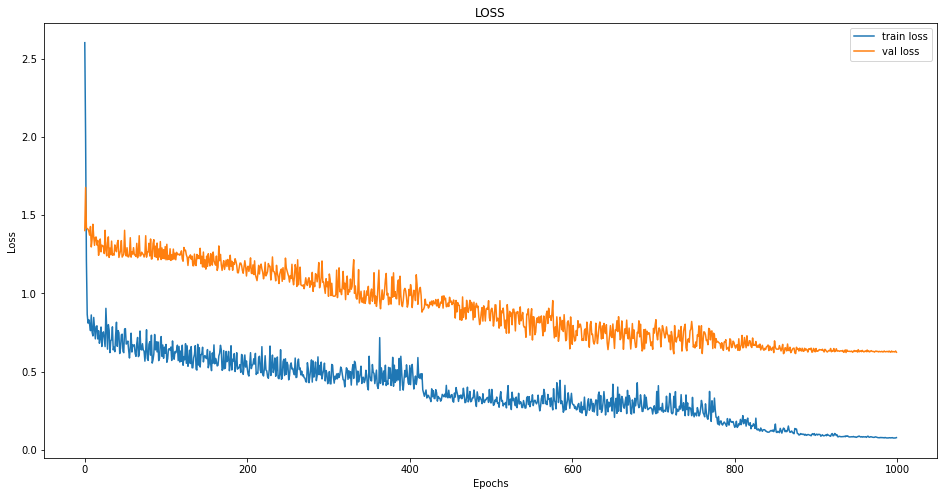

predicting base on test outfile2....
2/2 [==============================] - 0s 9ms/step
RMSE: 0.4040
MAE: 0.2627
MSE: 0.1632
Rsquare: 0.8752
___finished___

predicting base on test outfile3....
2/2 [==============================] - 0s 13ms/step
RMSE: 0.3948
MAE: 0.2812
MSE: 0.1558
Rsquare: 0.8453
___finished___


In [ ]:
#LSTM
lstm_obj40mmf1 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj40mmf1 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile1, gridsize = 40...

predicting base on test outfile2
RMSE: 0.4550
MAE: 0.2739
MSE: 0.2070
R^2: 0.8416
___finished___

predicting base on test outfile3
RMSE: 0.3719
MAE: 0.2826
MSE: 0.1383
R^2: 0.8627
___finished___


In [ ]:
# LASSO
# lasso_obj20mmf1 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)


## file2

In [ ]:
trainfilenum = 2

testfile1num = 1
testfile2num = 3

LSTM Model build base on file2
LSTM Model Loss history when build base on file2


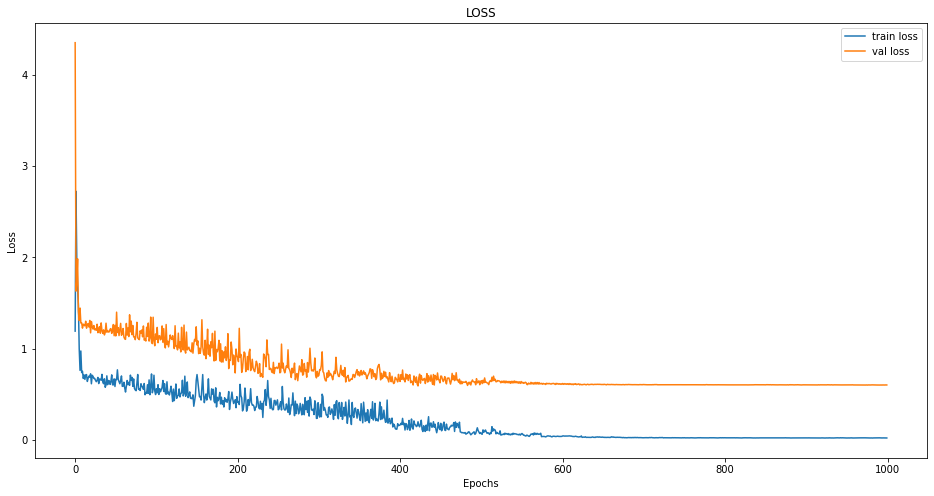

predicting base on test outfile1....
2/2 [==============================] - 0s 10ms/step
RMSE: 0.4527
MAE: 0.2874
MSE: 0.2049
Rsquare: 0.8487
___finished___

predicting base on test outfile3....
2/2 [==============================] - 0s 11ms/step
RMSE: 0.3518
MAE: 0.2527
MSE: 0.1238
Rsquare: 0.8771
___finished___


In [ ]:
#LSTM
lstm_obj40mmf2 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj40mmf2 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile2, gridsize = 40...

predicting base on test outfile1
RMSE: 0.4852
MAE: 0.3065
MSE: 0.2354
R^2: 0.8262
___finished___

predicting base on test outfile3
RMSE: 0.3669
MAE: 0.2623
MSE: 0.1346
R^2: 0.8664
___finished___


In [ ]:
# LASSO
# lasso_obj20mmf2 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

## file3

In [ ]:
trainfilenum = 3

testfile1num = 1
testfile2num = 2

LSTM Model build base on file3
LSTM Model Loss history when build base on file3


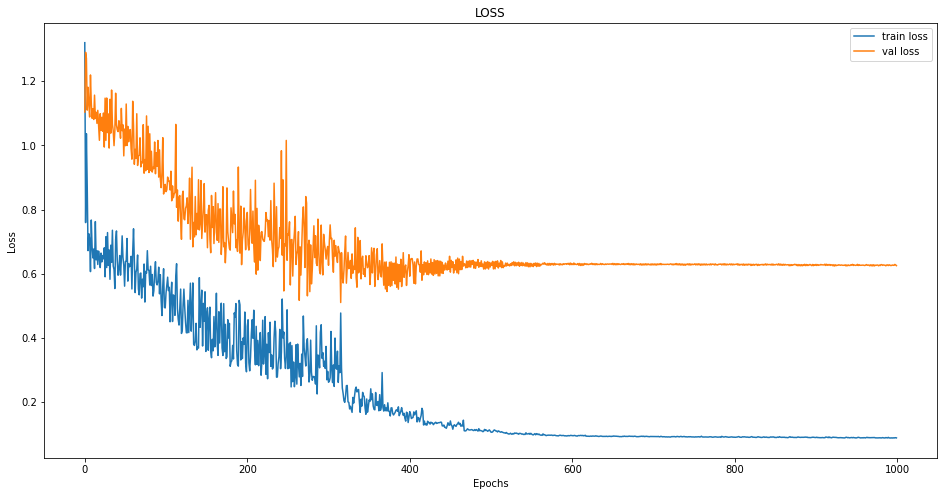

predicting base on test outfile1....
2/2 [==============================] - 0s 8ms/step
RMSE: 0.6275
MAE: 0.3981
MSE: 0.3937
Rsquare: 0.7094
___finished___

predicting base on test outfile2....
2/2 [==============================] - 0s 16ms/step
RMSE: 0.5911
MAE: 0.3596
MSE: 0.3494
Rsquare: 0.7327
___finished___


In [ ]:
#LSTM
lstm_obj40mmf3 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj40mmf3 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile3, gridsize = 40...

predicting base on test outfile1
RMSE: 0.5482
MAE: 0.3527
MSE: 0.3005
R^2: 0.7782
___finished___

predicting base on test outfile2
RMSE: 0.5315
MAE: 0.3565
MSE: 0.2825
R^2: 0.7839
___finished___


In [ ]:
# LASSO
# lasso_obj20mmf3 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

# 50 mm model

In [ ]:
gsize = 50

## file1

In [ ]:
trainfilenum = 1

testfile1num = 2
testfile2num = 3

LSTM Model build base on file1
LSTM Model Loss history when build base on file1


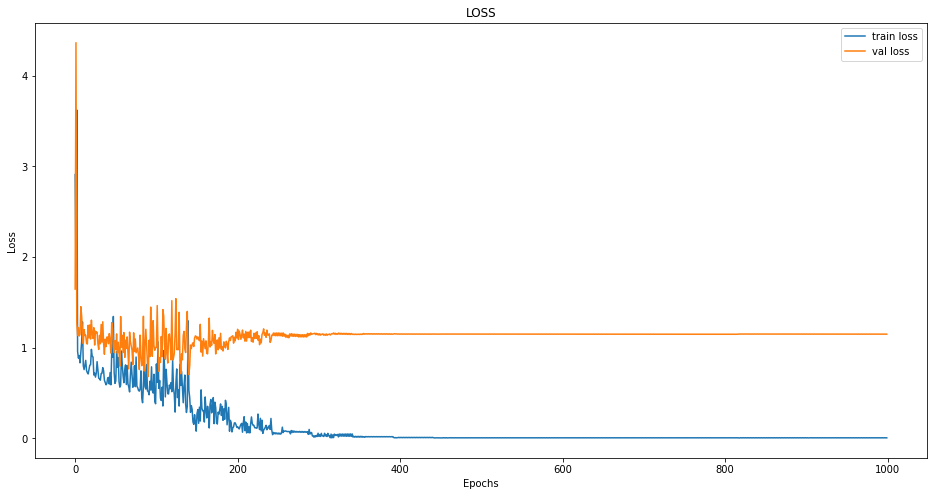

predicting base on test outfile2....
1/1 [==============================] - 1s 514ms/step
RMSE: 0.6126
MAE: 0.3790
MSE: 0.3753
Rsquare: 0.7593
___finished___

predicting base on test outfile3....
1/1 [==============================] - 0s 20ms/step
RMSE: 0.6103
MAE: 0.4399
MSE: 0.3724
Rsquare: 0.6896
___finished___


In [ ]:
#LSTM
lstm_obj40mmf1 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj40mmf1 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile1, gridsize = 50...

predicting base on test outfile2
RMSE: 0.5873
MAE: 0.3482
MSE: 0.3450
R^2: 0.7788
___finished___

predicting base on test outfile3
RMSE: 0.5536
MAE: 0.3679
MSE: 0.3065
R^2: 0.7446
___finished___


In [ ]:
# LASSO
# lasso_obj20mmf1 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)


## file2

In [ ]:
trainfilenum = 2

testfile1num = 1
testfile2num = 3

LSTM Model build base on file2
LSTM Model Loss history when build base on file2


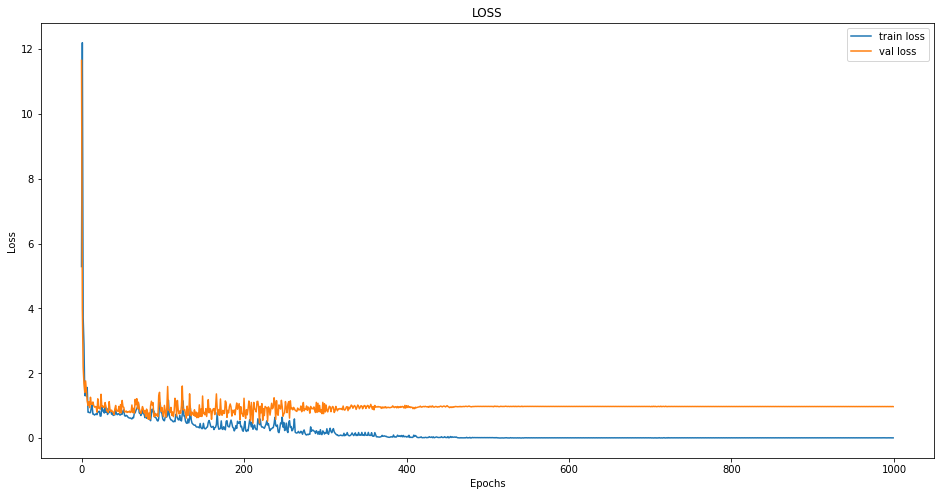

predicting base on test outfile1....
1/1 [==============================] - 0s 251ms/step
RMSE: 0.5958
MAE: 0.3454
MSE: 0.3550
Rsquare: 0.7693
___finished___

predicting base on test outfile3....
1/1 [==============================] - 0s 18ms/step
RMSE: 0.5907
MAE: 0.4258
MSE: 0.3489
Rsquare: 0.7092
___finished___


In [ ]:
#LSTM
lstm_obj40mmf2 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj40mmf2 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile2, gridsize = 50...

predicting base on test outfile1
RMSE: 0.6056
MAE: 0.3519
MSE: 0.3667
R^2: 0.7617
___finished___

predicting base on test outfile3
RMSE: 0.5648
MAE: 0.3865
MSE: 0.3190
R^2: 0.7341
___finished___


In [ ]:
# LASSO
# lasso_obj20mmf2 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

## file3

In [ ]:
trainfilenum = 3

testfile1num = 1
testfile2num = 2

LSTM Model build base on file3
LSTM Model Loss history when build base on file3


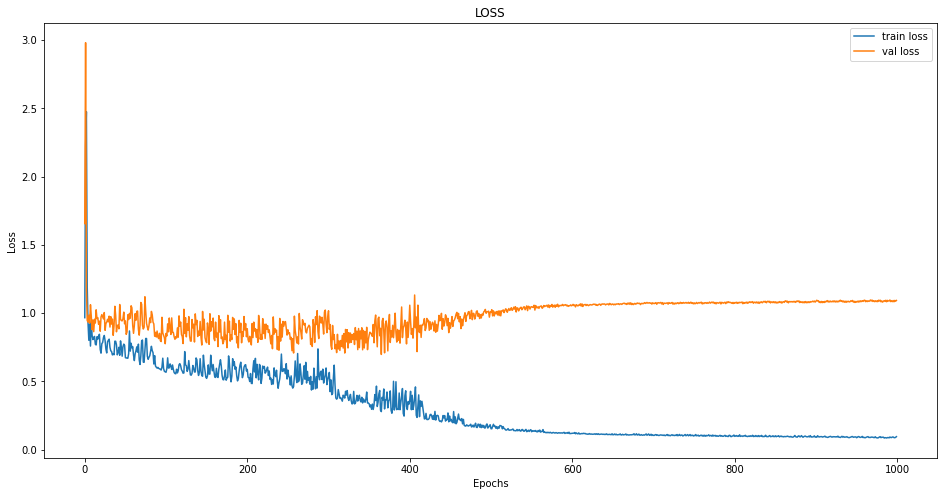

predicting base on test outfile1....
1/1 [==============================] - 0s 250ms/step
RMSE: 0.7677
MAE: 0.5269
MSE: 0.5894
Rsquare: 0.6170
___finished___

predicting base on test outfile2....
1/1 [==============================] - 0s 18ms/step
RMSE: 0.7703
MAE: 0.5370
MSE: 0.5933
Rsquare: 0.6195
___finished___


In [ ]:
#LSTM
lstm_obj40mmf3 = start_main(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle)

In [ ]:
#svm
svm_obj40mmf3 = svm_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

model build on outfile3, gridsize = 50...

predicting base on test outfile1
RMSE: 0.6277
MAE: 0.4413
MSE: 0.3940
R^2: 0.7440
___finished___

predicting base on test outfile2
RMSE: 0.6213
MAE: 0.4482
MSE: 0.3860
R^2: 0.7525
___finished___


# getresultforme

In [ ]:
# LASSO
# lasso_obj20mmf3 = lasso_reg_model(trainfilenum,testfile1num,testfile2num,batch,gsize,shuffle,seed)

In [ ]:
# lasso_obj2mmf1.getParameter_testb()

In [ ]:
# lasso_obj2mmf1.getParameter_testa()